In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


### Проверим данные:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [6]:
df.userid.nunique()

90189

In [7]:
df.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

#### Проверим, сколько человек установили игру, но не сыграли ни одного раунда:

In [13]:
df[df['sum_gamerounds'] == 0].shape[0]

3994

#### Посмотрим, сколько человек сыграли хотя бы один раунд, но не вернулись в игру через 1 день или неделю:

In [14]:
df[(df['retention_1'] == 0) & (df['retention_7'] == 0) & (df['sum_gamerounds'] > 0)]

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
3,483,gate_40,1,0,0
7,1444,gate_40,2,0,0
19,2502,gate_40,1,0,0
24,2829,gate_30,4,0,0
...,...,...,...,...,...
90178,9998555,gate_40,32,0,0
90180,9998623,gate_30,7,0,0
90183,9999349,gate_30,10,0,0
90185,9999479,gate_40,30,0,0


In [33]:
print(df[df['sum_gamerounds'] < 3000].userid.count())
df[df['sum_gamerounds'] > 3000]

90188


,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1


#### Для визуального анализа данных не будем учитывать аномалию в ~ 50 тысяч попыток, т.к. 99% попыток лежит в диапазоне от 0 до 3000.

In [26]:
df_vis = df[df['sum_gamerounds'] < 3000]
df_vis.shape

(90188, 5)

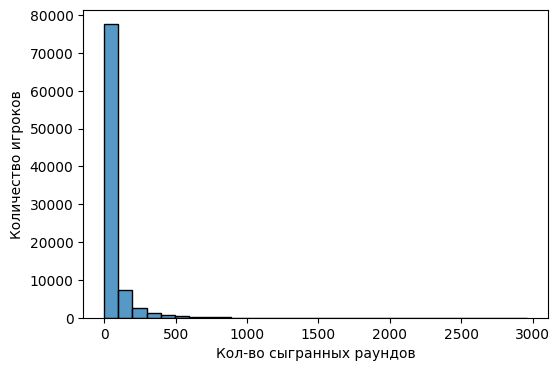

In [41]:
plt.figure(figsize=(6,4))
sns.histplot(df_vis['sum_gamerounds'], bins=30)

plt.xlabel('Кол-во сыгранных раундов')
plt.ylabel('Количество игроков');


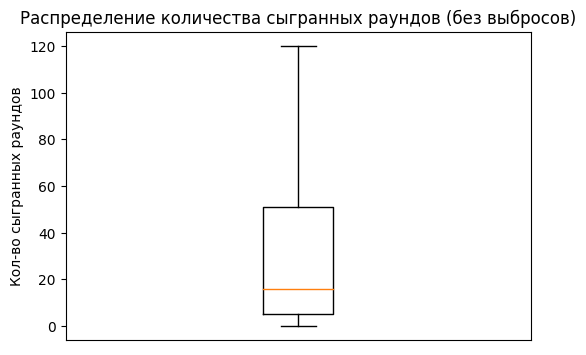

In [74]:
plt.figure(figsize=(6,4))
plt.boxplot(df_vis['sum_gamerounds'], showfliers=False)

plt.title('Распределение количества сыгранных раундов (без выбросов)')
plt.ylabel('Кол-во сыгранных раундов')
plt.gca().get_xaxis().set_visible(False);

#### Визуализируем таблицу возврата пользователей:

In [89]:
df_retention = df.groupby('version').agg({'userid':'count', 'retention_1':'mean', 'retention_7':'mean', 'sum_gamerounds':'sum'})
df_retention

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


In [116]:
n_control = df[df['version'] == 'gate_30']['userid'].count()
n_test = df[df['version'] == 'gate_40']['userid'].count()

In [117]:
ret1_control = df[(df['version'] == 'gate_30')].retention_1.sum()
ret1_test = df[(df['version'] == 'gate_40')].retention_1.sum()
ret7_control = df[(df['version'] == 'gate_30')].retention_7.sum()
ret7_test = df[(df['version'] == 'gate_40')].retention_7.sum()


In [99]:
from statsmodels.stats import proportion

#### Для оценки стат. значимости используем Хи квадрат:

__Retention_1__

In [100]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([ret1_control,ret1_test]),
                                                        np.array([n_control,n_test]))
print(round(chisq, 3), round(pvalue, 3))

3.183 0.074


##### Т.к. p-value > 0.05 делаем вывод о том, что стат. значимости между группами не обнаружено.

__Retention_7__

In [101]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([ret7_control,ret7_test]),
                                                        np.array([n_control,n_test]))
print(round(chisq, 3), round(pvalue, 3))

10.013 0.002


##### В данном случае p-value < 0.05. Соответственно, обнаружены статистически значимые различия между группами.

#### Также проверим себя, использовуя z тест:

__Retention_1__

In [102]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([ret1_control,ret1_test]),
                                                        np.array([n_control,n_test]))
print(round(z_score, 3), round(z_pvalue, 3))

1.784 0.074


__Retention_7__

In [103]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([ret7_control,ret7_test]),
                                                        np.array([n_control,n_test]))
print(round(z_score, 3), round(z_pvalue, 3))

3.164 0.002


##### Результаты тестов оказались равны.

#### Т.к. p-value Retention_1 оказалось близким по значению к alpha, попробуем провести тесты, используя __Bootstrap__:

In [113]:
from scipy.stats import *
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

__Retention_1__

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:19<00:00, 522.24it/s]


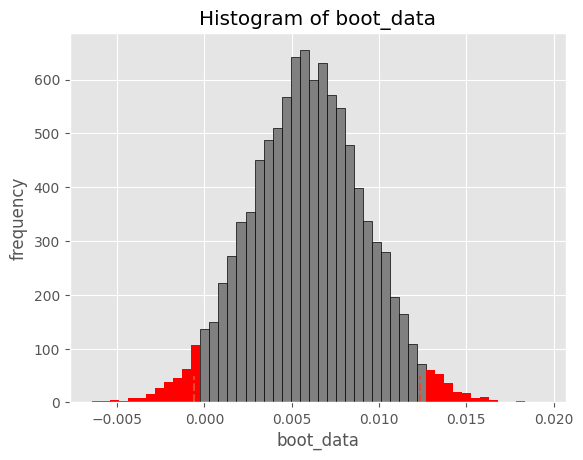

{'p_value': 0.07512402857478478}

In [114]:
get_bootstrap(df[df['version'] == 'gate_30']['retention_1'], df[df['version'] == 'gate_40']['retention_1'])

__Retention_7__

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:18<00:00, 535.73it/s]


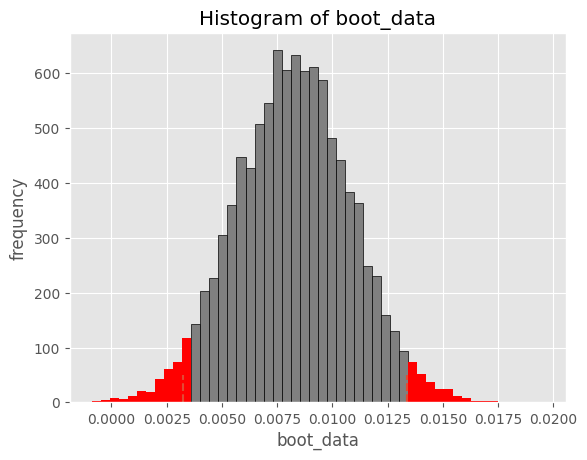

{'p_value': 0.0014956594371952666}

In [115]:
get_bootstrap(df[df['version'] == 'gate_30']['retention_7'], df[df['version'] == 'gate_40']['retention_7'])

##### Результаты бутстрапа оказались примерно равны результатам теста хи квадрата и z теста.

#### Вывод:
Статистически значимая разница обнаружена для метрики Retention 7ми дней. Для Retention 1ого дня разница не обнаружена, хотя значение критерия приграничное. Как бы то ни было, тестовая версия статистически показала себя хуже как минимум по одному параметру, поэтому следует отставить все как есть.